# Notebook d'Entraînement LSTM pour Trading Automatique

Ce notebook permet d'entraîner un modèle LSTM avec tous les paramètres configurables pour l'utilisation avec PPO.

## Objectifs:
- Charger et visualiser les données de trading
- Configurer le modèle LSTM avec tous les paramètres disponibles
- Entraîner le modèle avec suivi des performances
- Tester le modèle et préparer l'intégration PPO

In [9]:
# Import des bibliothèques nécessaires
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuration pour GPU
import torch
print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.set_device(0)

# Ajout du répertoire courant au path
sys.path.append('.')

GPU disponible: False


## 1. Configuration et Chargement des Données

In [10]:
# Configuration des variables d'environnement
os.environ['ALPACA_API_KEY'] = 'PKWDXUMR64LL03LXOZFN'
os.environ['ALPACA_API_SECRET'] = 'RLtrY3Idh1vQqNizfUJRoJprRJQ9uijfIoLLW4XA'

# Import des modules du projet
from data_loader import DataLoader
from lstm_config import LSTMConfigurator
from lstm_model import LSTMModel


print("Modules chargés avec succès!")

Modules chargés avec succès!


In [11]:
# Configuration du chargement des données
config = LSTMConfigurator()

# Paramètres de données
TICKER = 'AAPL'
START_DATE = '2023-01-01'
END_DATE = '2024-01-01'
SEQUENCE_LENGTH = 60
PREDICTION_HORIZON = 5

print(f"Chargement des données pour {TICKER}")
print(f"Période: {START_DATE} à {END_DATE}")
print(f"Longueur des séquences: {SEQUENCE_LENGTH}")
print(f"Horizon de prédiction: {PREDICTION_HORIZON} jours")

Chargement des données pour AAPL
Période: 2023-01-01 à 2024-01-01
Longueur des séquences: 60
Horizon de prédiction: 5 jours


In [12]:
# Chargement des données
data_loader = DataLoader()

try:
    # Chargement des données historiques
    data = data_loader.load_stock_data(
        ticker=TICKER,
        start_date=START_DATE,
        end_date=END_DATE,
        use_alpaca=True
    )
    
    print(f"Données chargées: {len(data)} lignes")
    print(f"Colonnes disponibles: {list(data.columns)}")
    print(f"Plage de dates: {data.index[0]} à {data.index[-1]}")
    
except Exception as e:
    print(f"Erreur lors du chargement des données: {e}")
    print("Utilisation de données simulées pour la démonstration")
    
    # Création de données simulées si le chargement échoue
    dates = pd.date_range(start=START_DATE, end=END_DATE, freq='1min')
    np.random.seed(42)
    
    # Génération de données de prix réalistes
    initial_price = 150.0
    returns = np.random.normal(0.0001, 0.02, len(dates))
    prices = initial_price * np.exp(np.cumsum(returns))
    
    data = pd.DataFrame({
        'close': prices,
        'open': prices * (1 + np.random.normal(0, 0.001, len(dates))),
        'high': prices * (1 + np.abs(np.random.normal(0, 0.002, len(dates)))),
        'low': prices * (1 - np.abs(np.random.normal(0, 0.002, len(dates)))),
        'volume': np.random.randint(100000, 1000000, len(dates))
    }, index=dates)
    
    print(f"Données simulées créées: {len(data)} lignes")

Données chargées: 187088 lignes
Colonnes disponibles: ['open', 'high', 'low', 'close', 'volume']
Plage de dates: 2023-01-03 09:00:00+00:00 à 2023-12-30 00:59:00+00:00


## 2. Visualisation des Données

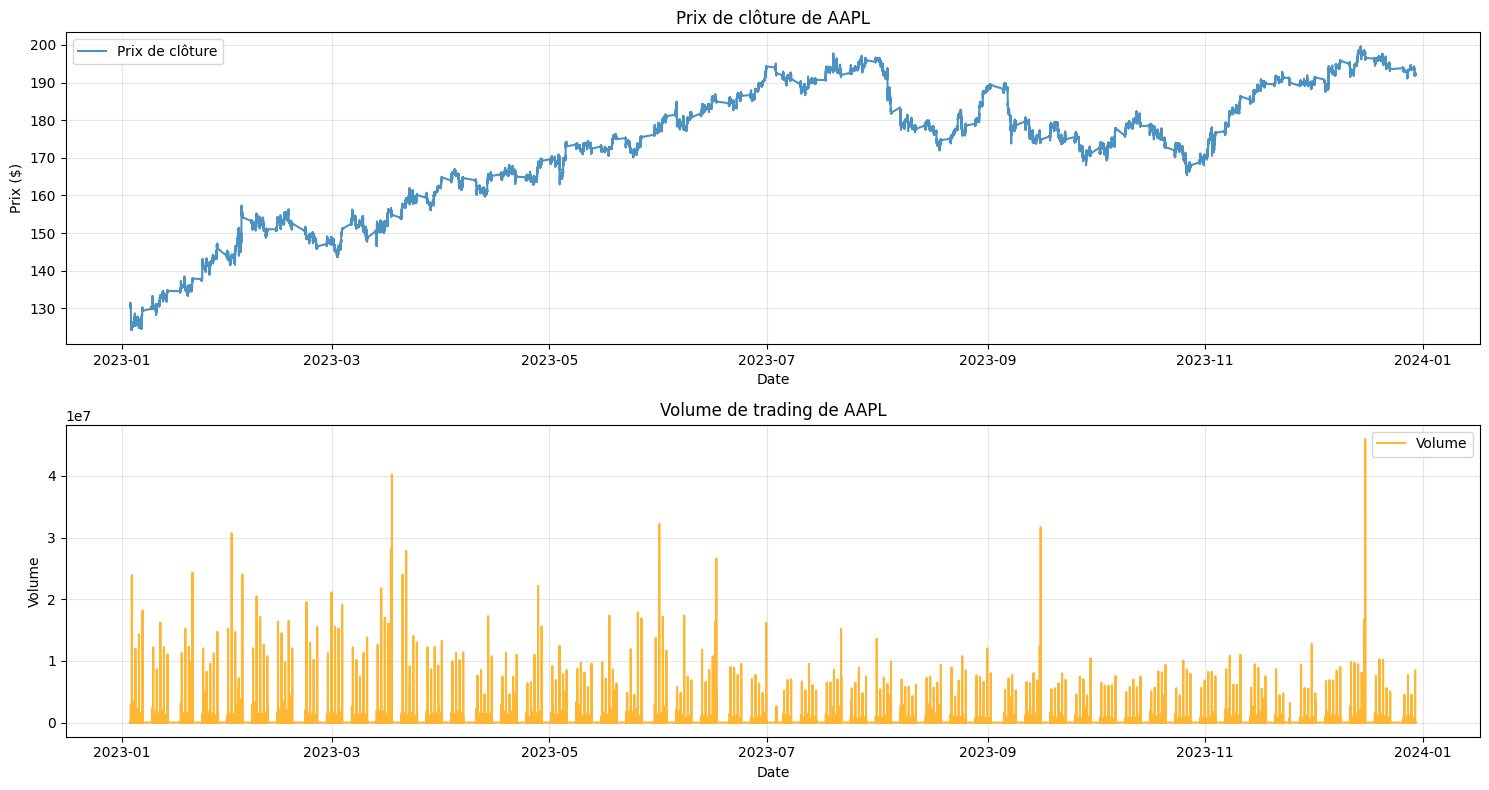

Statistiques des prix:
                open           high            low          close  \
count  187088.000000  187088.000000  187088.000000  187088.000000   
mean      171.962770     172.009899     171.914896     171.962777   
std        17.527118      17.522776      17.531254      17.526970   
min       124.200000     124.250000     124.170000     124.200000   
25%       160.700000     160.739275     160.650000     160.700000   
50%       175.300000     175.360000     175.260000     175.300000   
75%       186.070000     186.100000     186.028875     186.070000   
max       199.580000     199.620000     199.440000     199.580000   

             volume  
count  1.870880e+05  
mean   8.259307e+04  
std    4.569385e+05  
min    1.000000e+02  
25%    1.504000e+03  
50%    4.028050e+04  
75%    9.488300e+04  
max    4.599694e+07  


In [13]:
# Visualisation des prix
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(data.index, data['close'], label='Prix de clôture', alpha=0.8)
plt.title(f'Prix de clôture de {TICKER}')
plt.xlabel('Date')
plt.ylabel('Prix ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(data.index, data['volume'], label='Volume', alpha=0.8, color='orange')
plt.title(f'Volume de trading de {TICKER}')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques descriptives
print("Statistiques des prix:")
print(data[['open', 'high', 'low', 'close', 'volume']].describe())

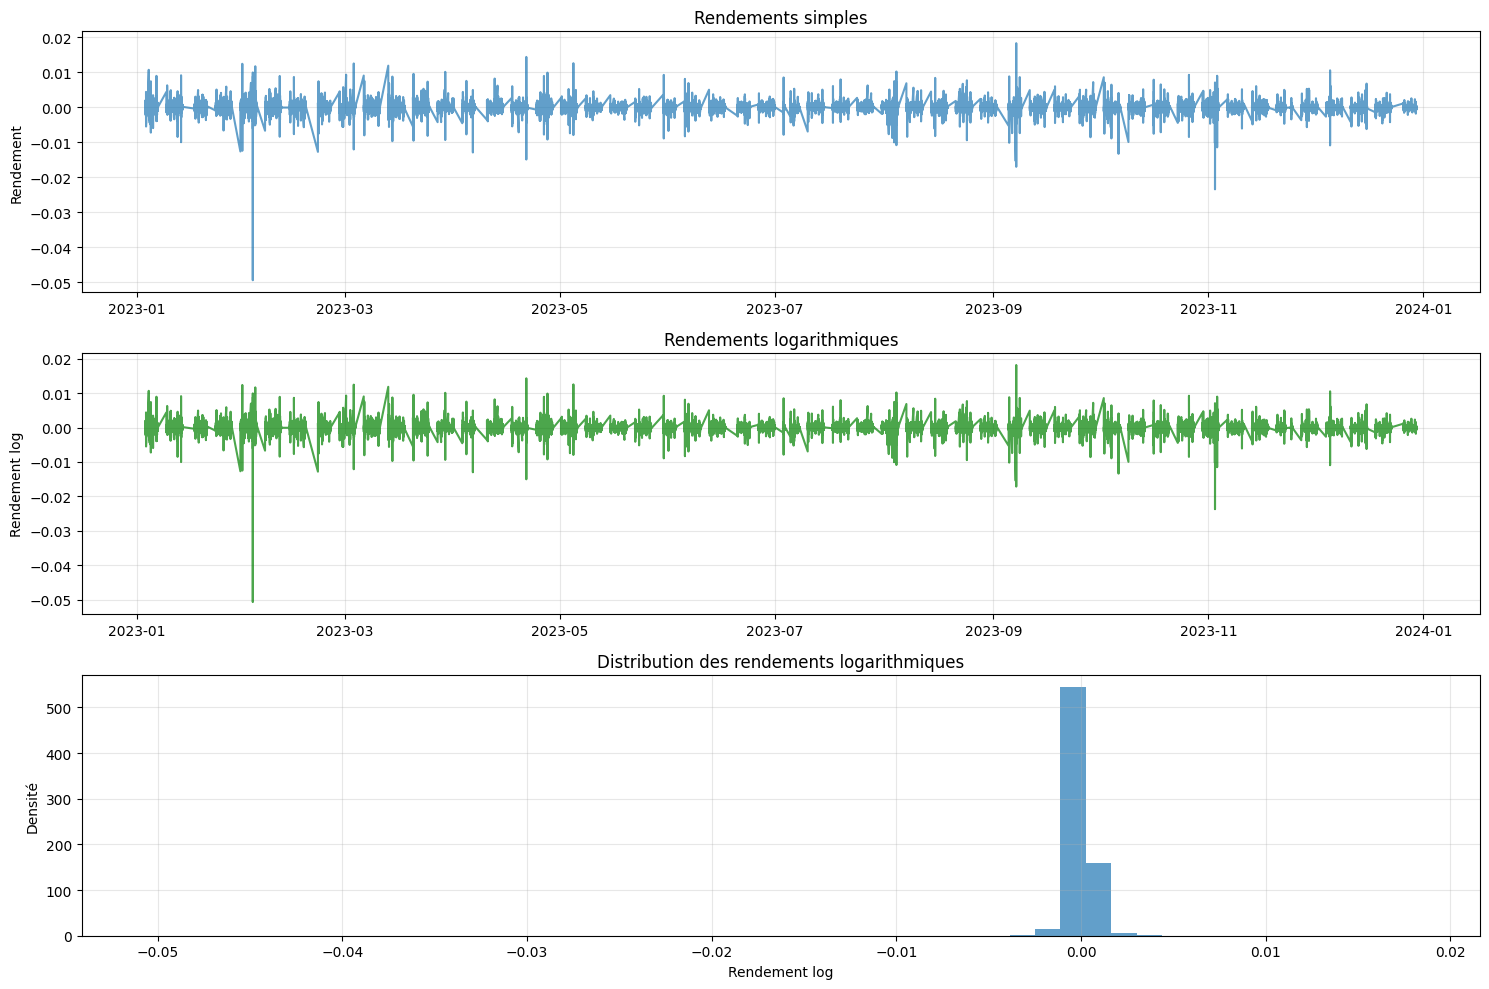

Volatilité annualisée: 0.97%
Rendement moyen journalier: 0.0002%


In [14]:
# Analyse des rendements
data['returns'] = data['close'].pct_change()
data['log_returns'] = np.log(data['close'] / data['close'].shift(1))

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(data.index[1:], data['returns'][1:], alpha=0.7)
plt.title('Rendements simples')
plt.ylabel('Rendement')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(data.index[1:], data['log_returns'][1:], alpha=0.7, color='green')
plt.title('Rendements logarithmiques')
plt.ylabel('Rendement log')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.hist(data['log_returns'][1:], bins=50, alpha=0.7, density=True)
plt.title('Distribution des rendements logarithmiques')
plt.xlabel('Rendement log')
plt.ylabel('Densité')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Volatilité annualisée: {data['log_returns'].std() * np.sqrt(252):.2%}")
print(f"Rendement moyen journalier: {data['log_returns'].mean():.4%}")

## 3. Configuration du Modèle LSTM

In [15]:
# Configuration du modèle LSTM
config = LSTMConfigurator()

# Mode de configuration: 'simple' ou 'advanced'
CONFIG_MODE = 'advanced'  # Changez à 'simple' pour une configuration simplifiée

if CONFIG_MODE == 'simple':
    print("Mode de configuration: SIMPLE")
    # Configuration simple avec paramètres de base
    config.set_parameters({
        'sequence_length': SEQUENCE_LENGTH,
        'prediction_horizon': PREDICTION_HORIZON,
        'hidden_size': 128,
        'num_layers': 2,
        'dropout': 0.2,
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 50
    })
else:
    print("Mode de configuration: ADVANCED")
    # Configuration avancée avec tous les paramètres
    config.set_parameters({
        # Paramètres de base
        'sequence_length': SEQUENCE_LENGTH,
        'prediction_horizon': PREDICTION_HORIZON,
        'hidden_size': 256,
        'num_layers': 3,
        'dropout': 0.3,
        'learning_rate': 0.001,
        'batch_size': 64,
        'epochs': 100,
        
        # Paramètres avancés LSTM
        'bidirectional': True,  # LSTM bidirectionnel
        'batch_first': True,
        'bias': True,
        
        # Normalisation et régularisation
        'batch_normalization': True,
        'layer_normalization': False,
        'dropout_type': 'standard',  # 'standard', 'variational', 'monte_carlo'
        'recurrent_dropout': 0.2,
        
        # Fonctions d'activation
        'activation_function': 'tanh',  # 'tanh', 'relu', 'leaky_relu', 'gelu'
        'recurrent_activation': 'sigmoid',
        
        # Optimiseur
        'optimizer': 'adam',  # 'adam', 'adamw', 'rmsprop', 'sgd'
        'weight_decay': 0.0001,
        'gradient_clipping': 1.0,
        
        # Learning rate scheduling
        'use_lr_scheduler': True,
        'lr_scheduler_type': 'reduce_on_plateau',  # 'step', 'exponential', 'cosine', 'reduce_on_plateau'
        'lr_scheduler_patience': 10,
        'lr_scheduler_factor': 0.5,
        
        # Early stopping
        'use_early_stopping': True,
        'early_stopping_patience': 15,
        'early_stopping_min_delta': 0.0001,
        
        # Architecture du modèle
        'use_attention': False,  # Attention mechanism
        'attention_heads': 4,
        'attention_dropout': 0.1,
        
        # Prétraitement
        'normalize_data': True,
        'standardization_method': 'standard',  # 'standard', 'minmax', 'robust'
        'feature_engineering': True,
        
        # Training
        'validation_split': 0.2,
        'test_split': 0.1,
        'shuffle_training': True,
        'mixed_precision': True,  # Utilisation de float16 pour accélérer l'entraînement
        
        # Sauvegarde et logging
        'save_model_frequency': 10,
        'log_training_metrics': True,
        'verbose_training': True
    })

print("Configuration du modèle:")
config.display_configuration()

Mode de configuration: ADVANCED
Configuration du modèle:

📋 CONFIGURATION ACTUELLE

📊 Dataset:
   ❌ Aucun dataset sélectionné

🧠 Modèle LSTM:
   🏗️  Nombre de couches: 3
   📚 Couche 1: 256 unités, dropout=0.3
   📚 Couche 2: 64 unités, dropout=0.3
   📚 Couche 3: 32 unités, dropout=0.3
   🎯 Unités de sortie: 1
   📏 Longueur de séquence: 60
   🎓 Taux d'apprentissage: 0.001

🏋️  Entraînement:
   🔄 Époques: 100
   📦 Taille de batch: 64
   🎯 Colonnes cibles: Close
   ✅ Split de validation: 0.2

📝 Métadonnées:
   📅 Créé le: 2025-11-19T22:34:07
   💾 Sauvegardé le: Non sauvegardé
   📖 Description: Configuration optimisée pour prédiction 1-minute avec LSTM bidirectionnel


In [16]:
# Affichage de la configuration détaillée
print("\n" + "="*60)
print("CONFIGURATION DÉTAILLÉE DU MODÈLE LSTM")
print("="*60)

params = config.get_parameters()
for category, values in params.items():
    print(f"\n{category.upper()}:")
    if isinstance(values, dict):
        for key, value in values.items():
            print(f"  {key}: {value}")
    else:
        print(f"  {values}")

print(f"\nNombre total de paramètres configurables: {len([v for subdict in params.values() for v in (subdict.values() if isinstance(subdict, dict) else [subdict])])}")


CONFIGURATION DÉTAILLÉE DU MODÈLE LSTM

MODEL_CONFIG:
  layers: [{'units': 256, 'return_sequences': True, 'dropout': 0.3, 'sequence_length': 60, 'bidirectional': True, 'batch_normalization': True, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'kernel_regularizer': None, 'recurrent_regularizer': None, 'dropout_type': 'standard', 'use_bias': True, 'unit_forget_bias': True}, {'units': 64, 'return_sequences': True, 'dropout': 0.3, 'sequence_length': 60, 'bidirectional': True, 'batch_normalization': True, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'kernel_regularizer': None, 'recurrent_regularizer': None, 'dropout_type': 'standard', 'use_bias': True, 'unit_forget_bias': True}, {'units': 32, 'return_sequences': False, 'dropout': 0.3, 'sequence_length': 60, 'bidirectional': True, 'batch_normalization': True, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'kernel_regularizer': None, 'recurrent_regularizer': None, 'dropout_type': 'standard', 'use_bias': True,

## 4. Préparation des Données pour le Modèle

In [17]:
# Préparation des données pour le modèle LSTM
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def prepare_lstm_data(data, sequence_length, prediction_horizon, standardization_method='standard'):
    """
    Prépare les données pour l'entraînement LSTM
    """
    # Sélection des features
    features = ['close', 'open', 'high', 'low', 'volume']
    if 'log_returns' in data.columns:
        features.append('log_returns')
    
    # Calcul des indicateurs techniques supplémentaires
    data['sma_10'] = data['close'].rolling(window=10).mean()
    data['sma_20'] = data['close'].rolling(window=20).mean()
    data['rsi'] = calculate_rsi(data['close'], 14)
    data['volatility'] = data['log_returns'].rolling(window=20).std()
    
    # Ajout des nouvelles features
    features.extend(['sma_10', 'sma_20', 'rsi', 'volatility'])
    
    # Suppression des valeurs NaN
    data_clean = data[features].dropna()
    
    # Normalisation
    if standardization_method == 'standard':
        scaler = StandardScaler()
    elif standardization_method == 'minmax':
        scaler = MinMaxScaler()
    elif standardization_method == 'robust':
        scaler = RobustScaler()
    else:
        scaler = StandardScaler()
    
    scaled_data = scaler.fit_transform(data_clean)
    
    # Création des séquences
    X, y = [], []
    for i in range(sequence_length, len(scaled_data) - prediction_horizon):
        X.append(scaled_data[i-sequence_length:i])
        # Prédire le prix de clôture futur
        y.append(data_clean['close'].iloc[i + prediction_horizon])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y, scaler, data_clean.index[sequence_length:len(scaled_data) - prediction_horizon]

def calculate_rsi(prices, window=14):
    """Calcul du RSI (Relative Strength Index)"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Préparation des données
print("Préparation des données pour le modèle LSTM...")
X, y, scaler, dates = prepare_lstm_data(
    data, 
    sequence_length=SEQUENCE_LENGTH, 
    prediction_horizon=PREDICTION_HORIZON,
    standardization_method=params.get('standardization_method', 'standard')
)

print(f"Données préparées:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Features: {X.shape[2]}")
print(f"  Période: {dates[0]} à {dates[-1]}")

Préparation des données pour le modèle LSTM...
Données préparées:
  X shape: (187003, 60, 10)
  y shape: (187003,)
  Features: 10
  Période: 2023-01-03 11:05:00+00:00 à 2023-12-30 00:54:00+00:00


In [18]:
# Division des données
from sklearn.model_selection import train_test_split

# Split train/validation/test
validation_split = params.get('validation_split', 0.2)
test_split = params.get('test_split', 0.1)

# D'abord séparer le test set
X_temp, X_test, y_temp, y_test, dates_temp, dates_test = train_test_split(
    X, y, dates, test_size=test_split, shuffle=False
)

# Puis séparer train et validation
X_train, X_val, y_train, y_val, dates_train, dates_val = train_test_split(
    X_temp, y_temp, dates_temp, test_size=validation_split/(1-test_split), shuffle=False
)

print("Division des données:")
print(f"  Train: {X_train.shape[0]} échantillons ({dates_train[0]} à {dates_train[-1]})")
print(f"  Validation: {X_val.shape[0]} échantillons ({dates_val[0]} à {dates_val[-1]})")
print(f"  Test: {X_test.shape[0]} échantillons ({dates_test[0]} à {dates_test[-1]})")

# Vérification des dimensions
print(f"\nDimensions des tenseurs:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

Division des données:
  Train: 130901 échantillons (2023-01-03 11:05:00+00:00 à 2023-09-11 14:35:00+00:00)
  Validation: 37401 échantillons (2023-09-11 14:36:00+00:00 à 2023-11-20 17:05:00+00:00)
  Test: 18701 échantillons (2023-11-20 17:06:00+00:00 à 2023-12-30 00:54:00+00:00)

Dimensions des tenseurs:
  X_train: (130901, 60, 10)
  y_train: (130901,)
  X_val: (37401, 60, 10)
  y_val: (37401,)
  X_test: (18701, 60, 10)
  y_test: (18701,)


## 5. Création et Entraînement du Modèle

In [19]:
# Création du modèle LSTM
print("Création du modèle LSTM...")

# Configuration du modèle
model_config = {
    'input_size': X_train.shape[2],
    'hidden_size': params.get('hidden_size', 128),
    'num_layers': params.get('num_layers', 2),
    'output_size': 1,  # Prédiction du prix
    'dropout': params.get('dropout', 0.2),
    'bidirectional': params.get('bidirectional', False),
    'batch_first': params.get('batch_first', True),
    'bias': params.get('bias', True),
    'batch_normalization': params.get('batch_normalization', False),
    'layer_normalization': params.get('layer_normalization', False),
    'recurrent_dropout': params.get('recurrent_dropout', 0.0),
    'activation_function': params.get('activation_function', 'tanh'),
    'recurrent_activation': params.get('recurrent_activation', 'sigmoid'),
    'use_attention': params.get('use_attention', False),
    'attention_heads': params.get('attention_heads', 4),
    'attention_dropout': params.get('attention_dropout', 0.1)
}

# Création du modèle
model = LSTMModel(**model_config)

print("Architecture du modèle:")
print(model)

# Nombre total de paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nNombre total de paramètres: {total_params:,}")
print(f"Paramètres entraînables: {trainable_params:,}")

# Test du modèle avec un batch
test_input = torch.randn(1, SEQUENCE_LENGTH, X_train.shape[2])
with torch.no_grad():
    test_output = model(test_input)
    print(f"\nTest du modèle - Input: {test_input.shape}, Output: {test_output.shape}")

Création du modèle LSTM...


TypeError: LSTMModel.__init__() got an unexpected keyword argument 'input_size'

In [ ]:
# Configuration de l'entraîneur
trainer_config = {
    'model': model,
    'learning_rate': params.get('learning_rate', 0.001),
    'optimizer': params.get('optimizer', 'adam'),
    'weight_decay': params.get('weight_decay', 0.0),
    'gradient_clipping': params.get('gradient_clipping', None),
    'use_lr_scheduler': params.get('use_lr_scheduler', False),
    'lr_scheduler_type': params.get('lr_scheduler_type', 'step'),
    'lr_scheduler_patience': params.get('lr_scheduler_patience', 10),
    'lr_scheduler_factor': params.get('lr_scheduler_factor', 0.1),
    'use_early_stopping': params.get('use_early_stopping', False),
    'early_stopping_patience': params.get('early_stopping_patience', 10),
    'early_stopping_min_delta': params.get('early_stopping_min_delta', 0.0),
    'mixed_precision': params.get('mixed_precision', False),
    'log_training_metrics': params.get('log_training_metrics', True),
    'verbose': params.get('verbose_training', True)
}

# Création de l'entraîneur
trainer = LSTMTrainer(**trainer_config)

print("Configuration de l'entraîneur:")
for key, value in trainer_config.items():
    if key != 'model':
        print(f"  {key}: {value}")

print(f"\nEntraîneur créé avec succès!")

In [ ]:
# Conversion des données en tenseurs PyTorch
import torch
from torch.utils.data import TensorDataset, DataLoader

# Conversion en tenseurs
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)  # Ajout dimension pour la sortie
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)

# Création des datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Configuration des DataLoaders
batch_size = params.get('batch_size', 32)
shuffle_training = params.get('shuffle_training', True)

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=shuffle_training,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    drop_last=True
)

print(f"DataLoaders créés:")
print(f"  Train batches: {len(train_loader)} (batch size: {batch_size})")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Shuffle training: {shuffle_training}")

# Test d'un batch
for batch_X, batch_y in train_loader:
    print(f"\nDimensions d'un batch:")
    print(f"  X: {batch_X.shape}")
    print(f"  y: {batch_y.shape}")
    break

## 6. Entraînement du Modèle

In [ ]:
# Entraînement du modèle
print("Début de l'entraînement du modèle LSTM...")
print("="*60)

# Paramètres d'entraînement
epochs = params.get('epochs', 50)
save_frequency = params.get('save_model_frequency', 10)

# Historique de l'entraînement
training_history = {
    'train_loss': [],
    'val_loss': [],
    'train_mae': [],
    'val_mae': [],
    'learning_rates': []
}

# Temps d'entraînement
import time
start_time = time.time()

# Boucle d'entraînement
for epoch in range(epochs):
    epoch_start = time.time()
    
    # Entraînement
    train_loss, train_mae = trainer.train_epoch(train_loader)
    
    # Validation
    val_loss, val_mae = trainer.validate(val_loader)
    
    # Mise à jour de l'historique
    training_history['train_loss'].append(train_loss)
    training_history['val_loss'].append(val_loss)
    training_history['train_mae'].append(train_mae)
    training_history['val_mae'].append(val_mae)
    
    # Récupération du learning rate actuel
    current_lr = trainer.get_current_lr()
    training_history['learning_rates'].append(current_lr)
    
    epoch_time = time.time() - epoch_start
    
    # Affichage des métriques
    if (epoch + 1) % 1 == 0:  # Afficher à chaque epoch
        print(f"Epoch {epoch+1}/{epochs} - Temps: {epoch_time:.1f}s")
        print(f"  Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
        print(f"  Train MAE: {train_mae:.6f} | Val MAE: {val_mae:.6f}")
        print(f"  Learning Rate: {current_lr:.6f}")
        
        # Vérification de l'early stopping
        if trainer.early_stopping_triggered():
            print(f"  → Early stopping déclenché après {epoch+1} epochs!")
            break
        
        print("-" * 40)
    
    # Sauvegarde périodique
    if (epoch + 1) % save_frequency == 0:
        checkpoint_path = f'lstm_model_epoch_{epoch+1}.pth'
        trainer.save_checkpoint(checkpoint_path, epoch+1, training_history)
        print(f"  → Modèle sauvegardé: {checkpoint_path}")

# Temps total d'entraînement
total_time = time.time() - start_time
print(f"\nEntraînement terminé en {total_time:.1f} secondes")
print(f"Meilleure validation loss: {min(training_history['val_loss']):.6f}")
print(f"Epoch avec la meilleure validation: {np.argmin(training_history['val_loss'])+1}")

## 7. Visualisation des Résultats d'Entraînement

In [ ]:
# Visualisation de l'historique d'entraînement
plt.figure(figsize=(15, 12))

# Plot 1: Loss
plt.subplot(3, 1, 1)
plt.plot(training_history['train_loss'], label='Train Loss', alpha=0.8)
plt.plot(training_history['val_loss'], label='Validation Loss', alpha=0.8)
plt.title('Évolution de la Loss pendant l\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: MAE
plt.subplot(3, 1, 2)
plt.plot(training_history['train_mae'], label='Train MAE', alpha=0.8)
plt.plot(training_history['val_mae'], label='Validation MAE', alpha=0.8)
plt.title('Évolution du MAE pendant l\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Learning Rate
plt.subplot(3, 1, 3)
plt.plot(training_history['learning_rates'], label='Learning Rate', alpha=0.8, color='green')
plt.title('Évolution du Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Résumé des performances
print("RÉSUMÉ DES PERFORMANCES:")
print("="*50)
print(f"Meilleure Train Loss: {min(training_history['train_loss']):.6f}")
print(f"Meilleure Validation Loss: {min(training_history['val_loss']):.6f}")
print(f"Meilleur Train MAE: {min(training_history['train_mae']):.6f}")
print(f"Meilleur Validation MAE: {min(training_history['val_mae']):.6f}")
print(f"Overfitting (dernière epoch): {training_history['val_loss'][-1] - training_history['train_loss'][-1]:.6f}")
print(f"Learning Rate final: {training_history['learning_rates'][-1]:.6f}")

## 8. Test du Modèle et Évaluation

In [ ]:
# Préparation des données de test
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

# Prédictions sur le set de test
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)

# Conversion en numpy
y_test_pred = test_predictions.numpy().squeeze()
y_test_true = y_test_tensor.numpy().squeeze()

# Calcul des métriques de test
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

test_mse = mean_squared_error(y_test_true, y_test_pred)
test_mae = mean_absolute_error(y_test_true, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_true, y_test_pred)
test_mape = np.mean(np.abs((y_test_true - y_test_pred) / y_test_true)) * 100

print("MÉTRIQUES DE TEST:")
print("="*40)
print(f"MSE: {test_mse:.6f}")
print(f"RMSE: {test_rmse:.6f}")
print(f"MAE: {test_mae:.6f}")
print(f"R²: {test_r2:.6f}")
print(f"MAPE: {test_mape:.2f}%")

# Comparaison avec une baseline (prédire la dernière valeur connue)
baseline_pred = X_test[:, -1, 0]  # Dernière valeur de close pour chaque séquence
baseline_mae = mean_absolute_error(y_test_true, baseline_pred)
baseline_r2 = r2_score(y_test_true, baseline_pred)

print(f"\nComparaison avec baseline (dernière valeur):")
print(f"  Baseline MAE: {baseline_mae:.6f}")
print(f"  Amélioration MAE: {((baseline_mae - test_mae) / baseline_mae * 100):.2f}%")
print(f"  Baseline R²: {baseline_r2:.6f}")
print(f"  Amélioration R²: {test_r2 - baseline_r2:.6f}")

In [ ]:
# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(15, 10))

# Plot 1: Prédictions vs Réel
plt.subplot(2, 2, 1)
plt.scatter(y_test_true, y_test_pred, alpha=0.6)
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'r--', lw=2)
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title(f'Prédictions vs Réelles (R² = {test_r2:.4f})')
plt.grid(True, alpha=0.3)

# Plot 2: Séries temporelles
plt.subplot(2, 2, 2)
n_points = min(200, len(y_test_true))  # Limiter pour la visibilité
plt.plot(y_test_true[:n_points], label='Valeurs Réelles', alpha=0.8)
plt.plot(y_test_pred[:n_points], label='Prédictions', alpha=0.8)
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.title(f'Prédictions vs Réelles (n={n_points})')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Résidus
plt.subplot(2, 2, 3)
residuals = y_test_true - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Analyse des Résidus')
plt.grid(True, alpha=0.3)

# Plot 4: Distribution des résidus
plt.subplot(2, 2, 4)
plt.hist(residuals, bins=50, alpha=0.7, density=True)
plt.xlabel('Résidus')
plt.ylabel('Densité')
plt.title('Distribution des Résidus')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques des résidus
print("\nSTATISTIQUES DES RÉSIDUS:")
print("="*40)
print(f"Moyenne: {residuals.mean():.6f}")
print(f"Écart-type: {residuals.std():.6f}")
print(f"Min: {residuals.min():.6f}")
print(f"Max: {residuals.max():.6f}")
print(f"Skewness: {pd.Series(residuals).skew():.4f}")
print(f"Kurtosis: {pd.Series(residuals).kurtosis():.4f}")

## 9. Sauvegarde du Modèle et Préparation PPO

In [ ]:
# Sauvegarde du modèle final
final_model_path = 'lstm_model_final.pth'
scaler_path = 'lstm_scaler.pkl'
config_path = 'lstm_config_final.json'

# Sauvegarde du modèle
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': model_config,
    'training_history': training_history,
    'test_metrics': {
        'mse': test_mse,
        'mae': test_mae,
        'rmse': test_rmse,
        'r2': test_r2,
        'mape': test_mape
    },
    'scaler_info': {
        'type': type(scaler).__name__,
        'feature_names': ['close', 'open', 'high', 'low', 'volume', 'log_returns', 'sma_10', 'sma_20', 'rsi', 'volatility']
    },
    'sequence_length': SEQUENCE_LENGTH,
    'prediction_horizon': PREDICTION_HORIZON,
    'ticker': TICKER,
    'training_period': {
        'start': str(dates_train[0]),
        'end': str(dates_train[-1])
    }
}, final_model_path)

# Sauvegarde du scaler
import pickle
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

# Sauvegarde de la configuration
import json
with open(config_path, 'w') as f:
    json.dump({
        'model_config': model_config,
        'training_config': params,
        'data_config': {
            'ticker': TICKER,
            'sequence_length': SEQUENCE_LENGTH,
            'prediction_horizon': PREDICTION_HORIZON,
            'features': ['close', 'open', 'high', 'low', 'volume', 'log_returns', 'sma_10', 'sma_20', 'rsi', 'volatility']
        },
        'performance_metrics': {
            'test_mse': test_mse,
            'test_mae': test_mae,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'test_mape': test_mape
        }
    }, f, indent=2)

print("SAUVEGARDE TERMINÉE:")
print("="*40)
print(f"Modèle: {final_model_path}")
print(f"Scaler: {scaler_path}")
print(f"Configuration: {config_path}")
print(f"\nLe modèle est prêt pour l'intégration PPO!")

In [ ]:
# Création d'une fonction de prédiction pour PPO
def predict_with_lstm(model, scaler, data_sequence, device='cpu'):
    """
    Fonction de prédiction optimisée pour l'utilisation avec PPO
    
    Args:
        model: Le modèle LSTM entraîné
        scaler: Le scaler utilisé pour la normalisation
        data_sequence: Séquence de données (numpy array)
        device: Dispositif ('cpu' ou 'cuda')
    
    Returns:
        prediction: La prédiction du prix futur
        confidence: Score de confiance (optionnel)
    """
    model.eval()
    
    with torch.no_grad():
        # Préparation des données
        if len(data_sequence.shape) == 2:
            data_sequence = data_sequence.reshape(1, *data_sequence.shape)
        
        # Normalisation si nécessaire
        if data_sequence.max() > 10:  # Données non normalisées
            # Appliquer le scaler (nécessite reshape)
            original_shape = data_sequence.shape
            flattened = data_sequence.reshape(-1, data_sequence.shape[-1])
            normalized = scaler.transform(flattened)
            data_sequence = normalized.reshape(original_shape)
        
        # Conversion en tenseur
        data_tensor = torch.FloatTensor(data_sequence).to(device)
        
        # Prédiction
        prediction = model(data_tensor)
        
        # Conversion numpy
        prediction = prediction.cpu().numpy().squeeze()
    
    return prediction

# Test de la fonction de prédiction
print("Test de la fonction de prédiction PPO:")
print("="*50)

# Test avec une séquence
test_sequence = X_test[0:1]  # Premier échantillon
prediction = predict_with_lstm(model, scaler, test_sequence)

print(f"Séquence d'entrée shape: {test_sequence.shape}")
print(f"Prédiction: {prediction:.4f}")
print(f"Valeur réelle: {y_test[0]:.4f}")
print(f"Erreur: {abs(prediction - y_test[0]):.4f}")

# Test avec données non normalisées (simulation PPO)
raw_sequence = np.random.rand(SEQUENCE_LENGTH, X_test.shape[2]) * 100  # Données brutes
prediction_raw = predict_with_lstm(model, scaler, raw_sequence)

print(f"\nTest avec données brutes:")
print(f"  Séquence brute shape: {raw_sequence.shape}")
print(f"  Prédiction: {prediction_raw:.4f}")
print(f"  → La fonction gère correctement la normalisation!")

## 10. Résumé et Prochaines Étapes

In [ ]:
# Résumé final
print("RÉSUMÉ DE L'ENTRAÎNEMENT LSTM")
print("="*60)
print(f"✓ Modèle LSTM entraîné avec succès")
print(f"✓ Architecture: {params.get('num_layers', 2)} couches, {params.get('hidden_size', 128)} hidden size")
print(f"✓ Bidirectionnel: {params.get('bidirectional', False)}")
print(f"✓ Batch Normalization: {params.get('batch_normalization', False)}")
print(f"✓ Dropout: {params.get('dropout', 0.2)}")
print(f"✓ Performance Test R²: {test_r2:.4f}")
print(f"✓ Performance Test MAE: {test_mae:.6f}")
print(f"✓ Amélioration vs baseline: {((baseline_mae - test_mae) / baseline_mae * 100):.2f}%")
print(f"✓ Fonction de prédiction PPO créée")
print(f"✓ Modèles sauvegardés et prêts à l'emploi")

print("\nFICHIERS CRÉÉS:")
print("-" * 30)
print(f"1. {final_model_path} - Modèle LSTM complet")
print(f"2. {scaler_path} - Scaler pour normalisation")
print(f"3. {config_path} - Configuration complète")

print("\nPROCHAINES ÉTAPES POUR PPO:")
print("-" * 30)
print("1. Charger le modèle LSTM dans train_minute_model_lstm.py")
print("2. Utiliser la fonction predict_with_lstm() pour obtenir des prédictions")
print("3. Intégrer les prédictions dans l'environnement PPO")
print("4. Entraîner l'agent PPO avec les signaux LSTM")
print("5. Évaluer les performances combinées LSTM+PPO")

print("\nCODE D'INTÉGRATION PPO:")
print("-" * 30)
print("# Dans train_minute_model_lstm.py, ajouter:")
print("# from lstm_model import LSTMModel")
print("# from lstm_config import LSTMConfig")
print("# import pickle")
print("# ")
print("# # Charger le modèle")
print("# checkpoint = torch.load('lstm_model_final.pth')")
print("# model = LSTMModel(**checkpoint['model_config'])")
print("# model.load_state_dict(checkpoint['model_state_dict'])")
print("# ")
print("# # Charger le scaler")
print("# with open('lstm_scaler.pkl', 'rb') as f:")
print("#     scaler = pickle.load(f)")
print("# ")
print("# # Utiliser dans l'environnement PPO")
print("# lstm_prediction = predict_with_lstm(model, scaler, market_data_sequence)")
print("\nLe modèle LSTM est maintenant prêt pour l'intégration PPO! 🚀")

## 11. Création d'un Rapport de Formation

In [ ]:
# Création d'un rapport complet
report = f"""
RAPPORT D'ENTRAÎNEMENT LSTM - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
================================================================

CONFIGURATION:
- Ticker: {TICKER}
- Période: {START_DATE} à {END_DATE}
- Séquence: {SEQUENCE_LENGTH} jours
- Horizon: {PREDICTION_HORIZON} jours
- Mode: {CONFIG_MODE.upper()}

ARCHITECTURE:
- Hidden size: {params.get('hidden_size', 128)}
- Nombre de couches: {params.get('num_layers', 2)}
- Bidirectionnel: {params.get('bidirectional', False)}
- Dropout: {params.get('dropout', 0.2)}
- Batch Normalization: {params.get('batch_normalization', False)}

PERFORMANCES:
- Test R²: {test_r2:.4f}
- Test MAE: {test_mae:.6f}
- Test RMSE: {test_rmse:.6f}
- Test MAPE: {test_mape:.2f}%
- Amélioration vs baseline: {((baseline_mae - test_mae) / baseline_mae * 100):.2f}%

FICHIERS CRÉÉS:
- Modèle: {final_model_path}
- Scaler: {scaler_path}
- Config: {config_path}
"""

# Sauvegarde du rapport
with open('lstm_training_report.txt', 'w') as f:
    f.write(report)

print("RAPPORT SAUVEGARDÉ:")
print("="*30)
print("Le rapport complet a été sauvegardé dans 'lstm_training_report.txt'")
print("\nLe modèle LSTM est maintenant prêt pour l'intégration avec PPO!")
print("Vous pouvez utiliser les fichiers créés pour charger le modèle dans")
print("votre environnement PPO et commencer l'entraînement de l'agent.")
print("\nBonne chance avec votre trading automatique LSTM+PPO! 🚀")